# Support Vector Regression (SVR) on Servo Dataset

This notebook implements SVR on the servo dataset which contains data about a servo system. The task is to predict the rise time of the servo mechanism based on two continuous gain settings and two discrete mechanical linkage choices.

## 1. Import Required Libraries

First, let's import all the necessary libraries for data loading, preprocessing, modeling, and visualization.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import keras

np.random.seed(42)

plt.style.use('ggplot')
sns.set_context("notebook", font_scale=1.2)

2025-04-29 10:44:49.007506: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 2. Load and Explore the Dataset

Let's load the servo dataset and explore its structure.

In [2]:
column_names = ['motor', 'screw', 'pgain', 'vgain', 'class']

try:
    df = pd.read_csv('data/servo.data', header=None, names=column_names)
except FileNotFoundError:
    df = pd.read_csv('../data/servo.data', header=None, names=column_names)

print("Dataset shape:", df.shape)
df.head()

Dataset shape: (167, 5)


,motor,screw,pgain,vgain,class
0,E,E,5,4,0.281251
1,B,D,6,5,0.506252
2,D,D,4,3,0.356251
3,B,A,3,2,5.500033
4,D,B,6,5,0.356251


In [3]:
df.describe(include='all')

,motor,screw,pgain,vgain,class
count,167,167,167.000000,167.000000,167.000000
unique,5,5,NaN,NaN,NaN
top,C,A,NaN,NaN,NaN
freq,40,42,NaN,NaN,NaN
mean,NaN,NaN,4.155689,2.538922,1.389708
std,NaN,NaN,1.017770,1.369850,1.559635
min,NaN,NaN,3.000000,1.000000,0.131250
25%,NaN,NaN,3.000000,1.000000,0.503126
50%,NaN,NaN,4.000000,2.000000,0.731254
75%,NaN,NaN,5.000000,4.000000,1.259369


In [4]:
print("Missing values:")
df.isnull().sum()

Missing values:


motor    0
screw    0
pgain    0
vgain    0
class    0
dtype: int64

## 3. Exploratory Data Analysis

Let's visualize the data to better understand the relationships between features and the target variable.

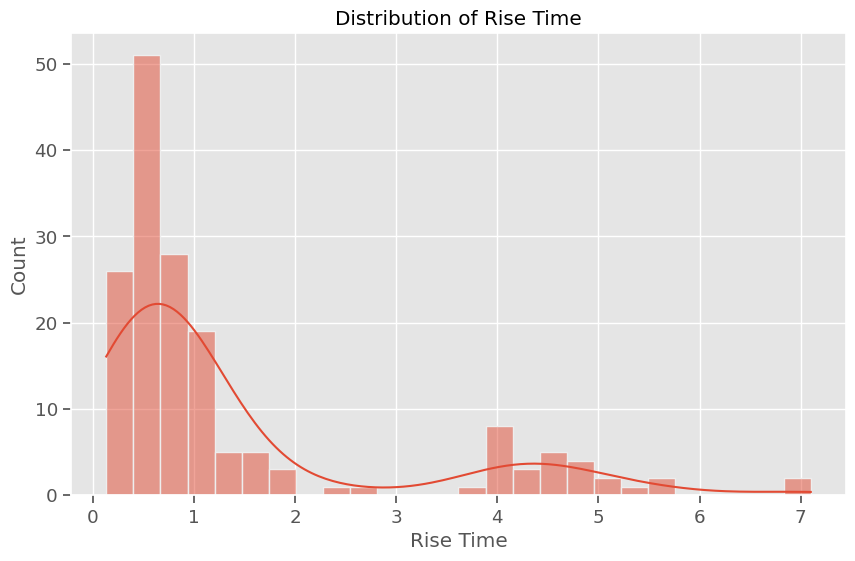

In [5]:
plt.figure(figsize=(10, 6))
sns.histplot(df['class'], kde=True)
plt.title('Distribution of Rise Time')
plt.xlabel('Rise Time')
plt.show()

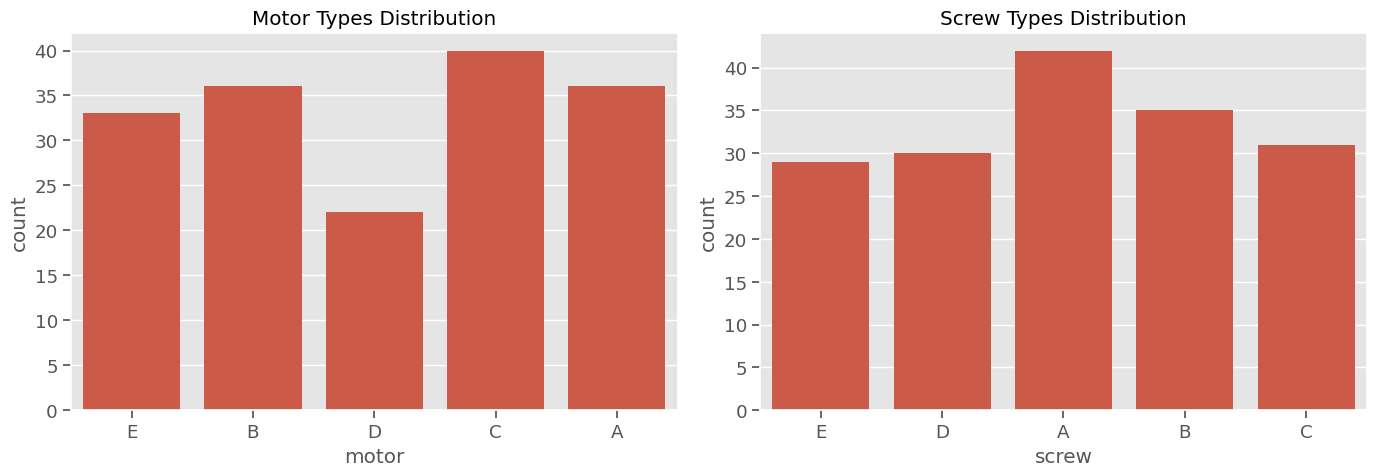

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.countplot(x='motor', data=df, ax=axes[0])
axes[0].set_title('Motor Types Distribution')
sns.countplot(x='screw', data=df, ax=axes[1])
axes[1].set_title('Screw Types Distribution')
plt.tight_layout()
plt.show()

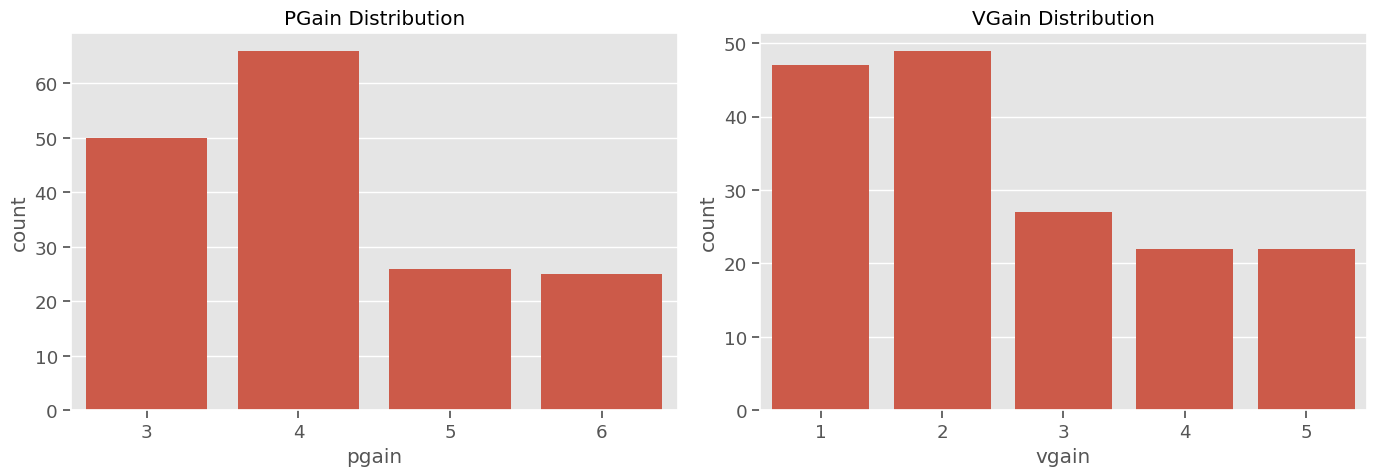

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.countplot(x='pgain', data=df, ax=axes[0])
axes[0].set_title('PGain Distribution')
sns.countplot(x='vgain', data=df, ax=axes[1])
axes[1].set_title('VGain Distribution')
plt.tight_layout()
plt.show()

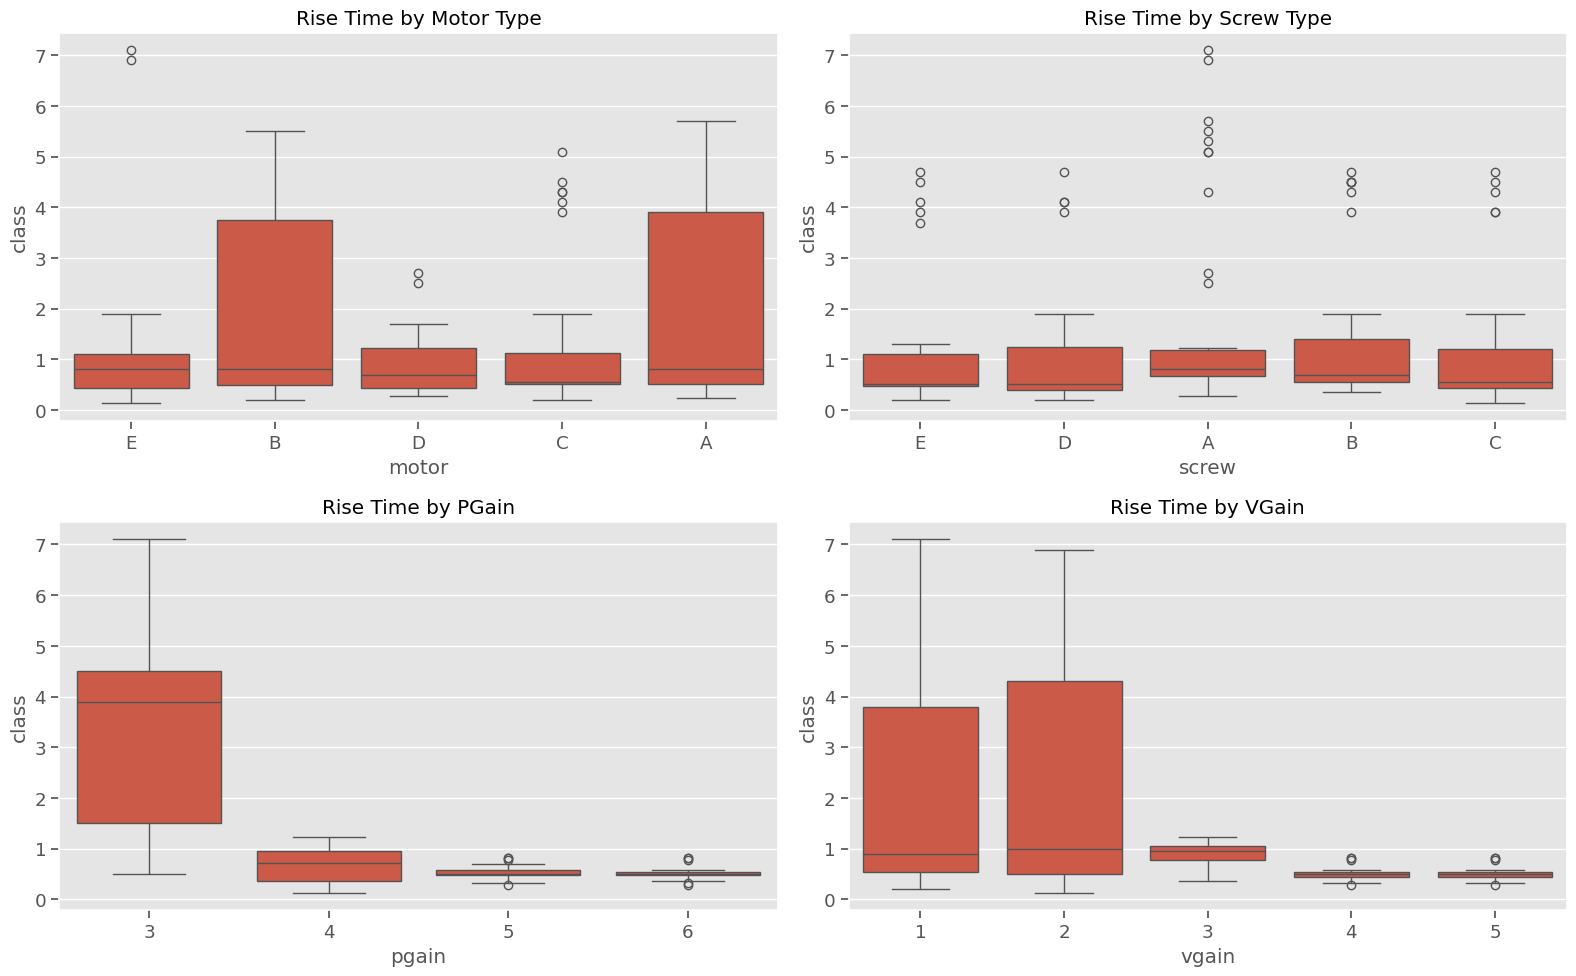

In [8]:
# Boxplot: Target value by categorical variables
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
sns.boxplot(x='motor', y='class', data=df, ax=axes[0, 0])
axes[0, 0].set_title('Rise Time by Motor Type')
sns.boxplot(x='screw', y='class', data=df, ax=axes[0, 1])
axes[0, 1].set_title('Rise Time by Screw Type')
sns.boxplot(x='pgain', y='class', data=df, ax=axes[1, 0])
axes[1, 0].set_title('Rise Time by PGain')
sns.boxplot(x='vgain', y='class', data=df, ax=axes[1, 1])
axes[1, 1].set_title('Rise Time by VGain')
plt.tight_layout()
plt.show()

## 4. Data Preprocessing

Now let's preprocess the data for modeling. We need to handle the categorical variables using one-hot encoding.

In [9]:
X = df.drop('class', axis=1)
y = df['class']

categorical_cols = ['motor', 'screw']
numerical_cols = ['pgain', 'vgain']

X['pgain'] = pd.to_numeric(X['pgain'])
X['vgain'] = pd.to_numeric(X['vgain'])

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")

Training set size: 133 samples
Testing set size: 34 samples


In [11]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols),
        ('num', StandardScaler(), numerical_cols)
    ]
)

# Fit the preprocessor on the training data
preprocessor.fit(X_train)

# Transform and convert to dense float32 arrays for compatibility with TensorFlow
X_train_processed = preprocessor.transform(X_train).astype('float32')
X_test_processed = preprocessor.transform(X_test).astype('float32')

# Extract one-hot encoded feature names
ohe_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
all_feature_names = list(ohe_feature_names) + numerical_cols

print("Feature names after preprocessing:")
print(all_feature_names)


Feature names after preprocessing:
['motor_B', 'motor_C', 'motor_D', 'motor_E', 'screw_B', 'screw_C', 'screw_D', 'screw_E', 'pgain', 'vgain']


## 5. Modeling

### 5.1. Artificial Neural Networks

Let's implement an artificial neural network and train it on the data

#### Model Architecture

* The neural network we are going to be using for this task consists of two hidden layers (the shallow layer contains 32 neurons and the deep one contains 16 neurons) and an output layer with one neuron 
* The architecture of the model is specified below 

In [35]:
ann_model = keras.Sequential([
    keras.layers.Input(shape=(X_train_processed.shape[1],)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(12, activation='relu'),
    keras.layers.Dense(1, activation='linear')
])

In [36]:
# specifying the optimizer and the metrics to evaluate the model
ann_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [37]:
history = ann_model.fit(
    X_train_processed, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=16,
    verbose=1
)

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 4.3863 - mae: 1.3206 - val_loss: 5.1821 - val_mae: 1.4235
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.1219 - mae: 1.0332 - val_loss: 4.6486 - val_mae: 1.2657
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.6171 - mae: 0.8986 - val_loss: 4.1385 - val_mae: 1.2081
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.2811 - mae: 0.8064 - val_loss: 3.6436 - val_mae: 1.1354
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.7742 - mae: 0.9448 - val_loss: 3.1677 - val_mae: 1.0537
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.2769 - mae: 0.9209 - val_loss: 2.7680 - val_mae: 1.0133
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.1709 - mae: 0.9238 - val_loss: 2.5078 - val_mae: 0.9830
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.4419 - mae: 0.7562 - val_loss: 2.3347 - val_mae: 0.9585
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.4599 - mae: 0.7794 -

#### Evaluating the model

In [38]:
# Ensure y_test is a float32 NumPy array
y_test = y_test.astype('float32')

# Make predictions on the test set
te_y_pred = ann_model.predict(X_test_processed)
tr_y_pred = ann_model.predict(X_train_processed)

# Flatten predictions if needed (in case they are shape (n, 1))
te_y_pred = te_y_pred.flatten()
tr_y_pred = tr_y_pred.flatten()

# Evaluate the model
te_mse = mean_squared_error(y_test, te_y_pred)
tr_mse = mean_squared_error(y_train, tr_y_pred)

te_rmse = np.sqrt(te_mse)
tr_rmse = np.sqrt(tr_mse)

te_mae = mean_absolute_error(y_test, te_y_pred)
tr_mae = mean_absolute_error(y_train, tr_y_pred)

te_r2 = r2_score(y_test, te_y_pred)
tr_r2 = r2_score(y_train, tr_y_pred)

print(f"Train Mean Squared Error: {tr_mse:.4f}")
print(f"Test Mean Squared Error: {te_mse:.4f}")
print(f"Train Root Mean Squared Error: {tr_rmse:.4f}")
print(f"Test Root Mean Squared Error: {te_rmse:.4f}")
print(f"Train Mean Absolute Error: {tr_mae:.4f}")
print(f"Test Mean Absolute Error: {te_mae:.4f}")
print(f"Train R² Score: {tr_r2:.4f}")
print(f"Test R² Score: {te_r2:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 602us/step
Train Mean Squared Error: 0.1154
Test Mean Squared Error: 0.1665
Train Root Mean Squared Error: 0.3397
Test Root Mean Squared Error: 0.4081
Train Mean Absolute Error: 0.1473
Test Mean Absolute Error: 0.2928
Train R² Score: 0.9521
Test R² Score: 0.9312


#### Visualizing Model Performance

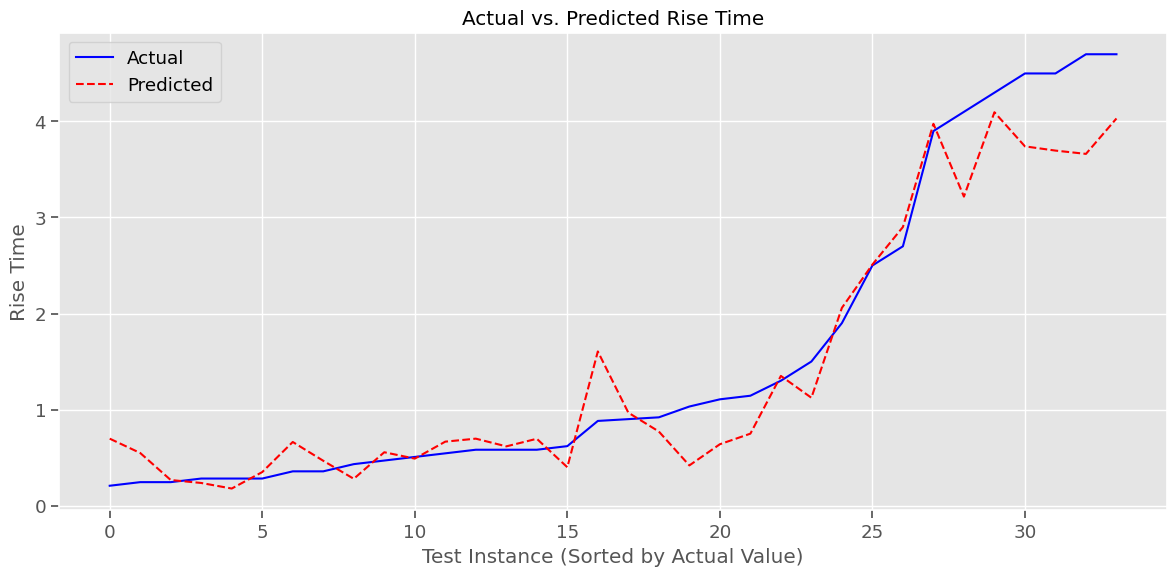

In [41]:
# Create a dataframe with actual and predicted values
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': te_y_pred})

# Sort by actual values for better visualization
results_df = results_df.sort_values(by='Actual')

# Plot actual vs. predicted
plt.figure(figsize=(12, 6))
plt.plot(results_df['Actual'].values, 'b-', label='Actual')
plt.plot(results_df['Predicted'].values, 'r--', label='Predicted')
plt.title('Actual vs. Predicted Rise Time')
plt.xlabel('Test Instance (Sorted by Actual Value)')
plt.ylabel('Rise Time')
plt.legend()
plt.tight_layout()
plt.show()

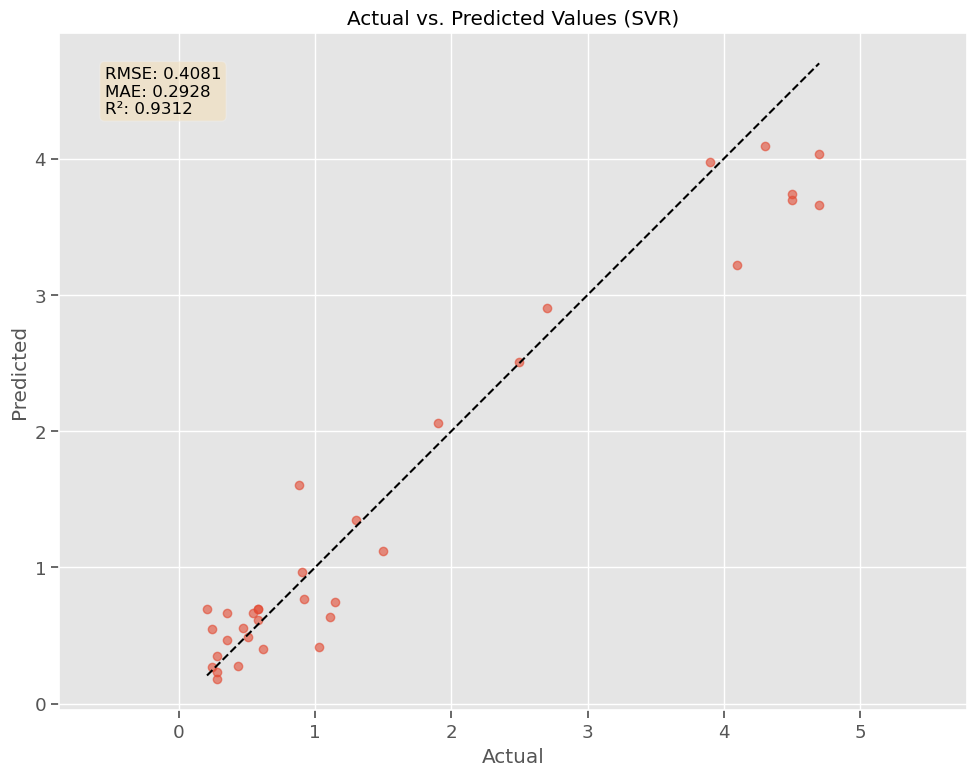

In [42]:
# Create a scatter plot of actual vs. predicted values
plt.figure(figsize=(10, 8))
plt.scatter(y_test, te_y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Values (SVR)')

# Calculate the range for aspect ratio
range_actual = y_test.max() - y_test.min()
range_pred = te_y_pred.max() - te_y_pred.min()
plt.axis('equal')
plt.grid(True)

# Add text box with metrics
textstr = f'\n'.join((
    f'RMSE: {te_rmse:.4f}',
    f'MAE: {te_mae:.4f}',
    f'R²: {te_r2:.4f}'
))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()

### 5.2. Support Vector Regression Implementation

Let's implement the SVR model and optimize its hyperparameters using GridSearchCV.

In [16]:
import time
from datetime import datetime
from sklearn.model_selection import RandomizedSearchCV

# Create the SVR pipeline
svr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', SVR())
])

# Define hyperparameter grid for SVR
param_grid = {
    'regressor__kernel': ['linear', 'rbf', 'poly'],
    'regressor__C': [0.01, 0.1, 1, 10, 100],
    'regressor__epsilon': [0.001, 0.01, 0.1, 0.2, 0.5],
    'regressor__gamma': ['scale', 'auto', 0.01, 0.1, 1.0],
    'regressor__degree': [2, 3],
    'regressor__coef0': [0.0, 1.0],
    'regressor__shrinking': [True, False]
}

# Print the total number of combinations
total_combinations = 3 * 5 * 5 * 5 * 2 * 2 * 2
print(f"Total parameter combinations: {total_combinations}")
print(f"Starting grid search at {datetime.now().strftime('%H:%M:%S')}")

# Choose which search method to use
use_randomized_search = True  # Set to False to use full grid search

if use_randomized_search:
    # Use RandomizedSearchCV for more efficient search
    print("Using RandomizedSearchCV with 100 iterations instead of full grid search")
    start_time = time.time()
    
    search = RandomizedSearchCV(
        svr_pipeline,
        param_distributions=param_grid,
        n_iter=100,  # Sample 100 parameter combinations
        cv=5,
        scoring='neg_mean_squared_error',
        verbose=2,  # More verbose output
        n_jobs=-1,
        random_state=42
    )
else:
    # Use full GridSearchCV (may take a long time)
    print("Using full GridSearchCV with all parameter combinations")
    start_time = time.time()
    
    search = GridSearchCV(
        svr_pipeline,
        param_grid,
        cv=5,
        scoring='neg_mean_squared_error',
        verbose=2,  # More verbose output
        n_jobs=-1
    )

# Fit the search
search.fit(X_train, y_train)

# Calculate and print execution time
end_time = time.time()
execution_time = end_time - start_time
print(f"\nSearch completed at {datetime.now().strftime('%H:%M:%S')}")
print(f"Total execution time: {execution_time:.2f} seconds ({execution_time/60:.2f} minutes)")

# Get the best parameters and best score
print("\nBest parameters:", search.best_params_)
print("Best cross-validation score: {:.4f}".format(-search.best_score_))

# Assign to grid_search for use in subsequent cells
grid_search = search

Total parameter combinations: 3000
Starting grid search at 10:44:56
Using RandomizedSearchCV with 100 iterations instead of full grid search
Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END regressor__C=10, regressor__coef0=0.0, regressor__degree=2, regressor__epsilon=0.001, regressor__gamma=scale, regressor__kernel=linear, regressor__shrinking=False; total time=   0.0s
[CV] END regressor__C=10, regressor__coef0=0.0, regressor__degree=2, regressor__epsilon=0.001, regressor__gamma=scale, regressor__kernel=linear, regressor__shrinking=False; total time=   0.0s
[CV] END regressor__C=10, regressor__coef0=0.0, regressor__degree=2, regressor__epsilon=0.001, regressor__gamma=0.01, regressor__kernel=poly, regressor__shrinking=False; total time=   0.0s
[CV] END regressor__C=10, regressor__coef0=0.0, regressor__degree=2, regressor__epsilon=0.001, regressor__gamma=0.01, regressor__kernel=poly, regressor__shrinking=False; total time=   0.0s
[CV] END regressor__C=10, regresso

In [39]:
# Get the best model
best_svr = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_svr.predict(X_test)
tr_y_pred = best_svr.predict(X_train)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
r2_tr = r2_score(y_train, tr_y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Test R² Score: {r2:.4f}")
print(f"TRain R² Score: {r2_tr:.4f}")

Mean Squared Error: 0.1122
Root Mean Squared Error: 0.3349
Mean Absolute Error: 0.2722
Test R² Score: 0.9536
TRain R² Score: 0.8895


## 6. Visualize Model Performance

Let's visualize how well our model predictions match the actual values.

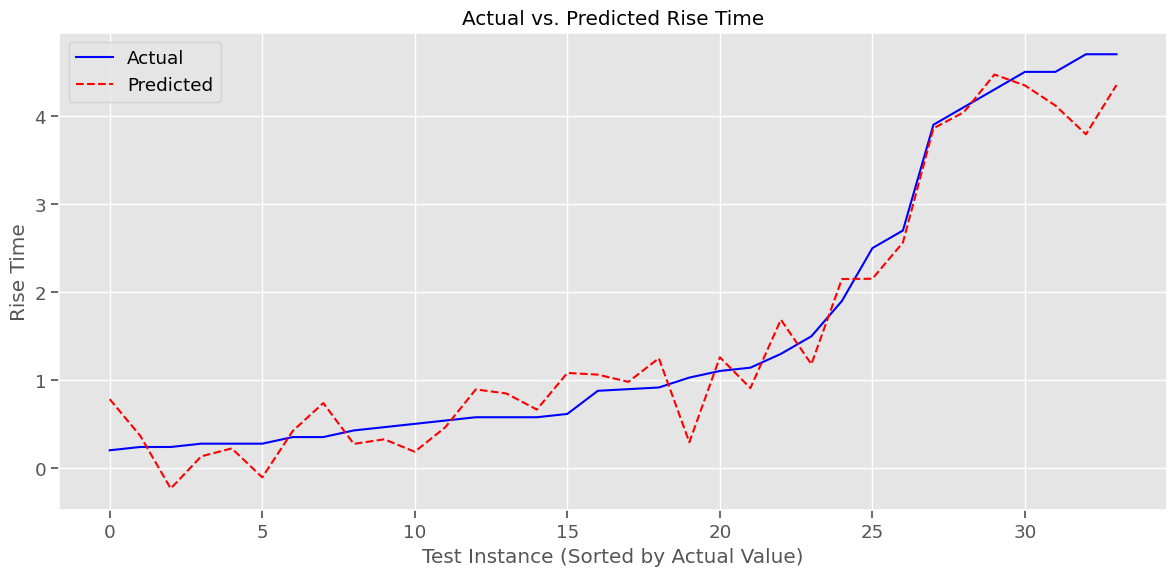

In [18]:
# Create a dataframe with actual and predicted values
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# Sort by actual values for better visualization
results_df = results_df.sort_values(by='Actual')

# Plot actual vs. predicted
plt.figure(figsize=(12, 6))
plt.plot(results_df['Actual'].values, 'b-', label='Actual')
plt.plot(results_df['Predicted'].values, 'r--', label='Predicted')
plt.title('Actual vs. Predicted Rise Time')
plt.xlabel('Test Instance (Sorted by Actual Value)')
plt.ylabel('Rise Time')
plt.legend()
plt.tight_layout()
plt.show()

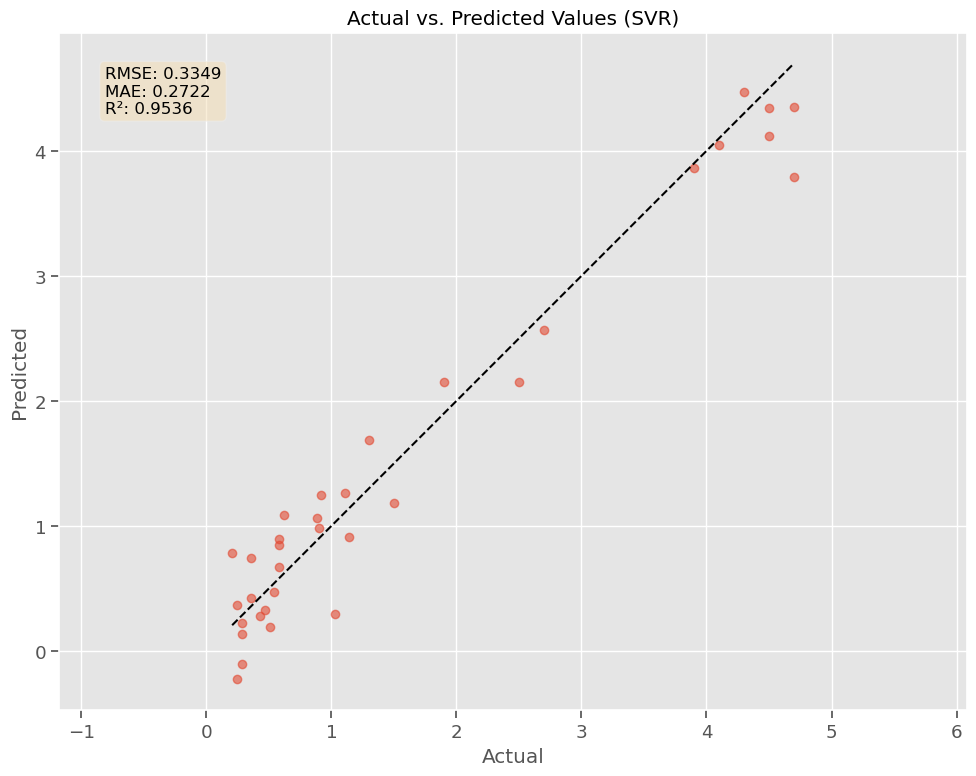

In [19]:
# Create a scatter plot of actual vs. predicted values
plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Values (SVR)')

# Calculate the range for aspect ratio
range_actual = y_test.max() - y_test.min()
range_pred = y_pred.max() - y_pred.min()
plt.axis('equal')
plt.grid(True)

# Add text box with metrics
textstr = f'\n'.join((
    f'RMSE: {rmse:.4f}',
    f'MAE: {mae:.4f}',
    f'R²: {r2:.4f}'
))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()

## 7. Residual Analysis

Let's analyze the residuals (prediction errors) to check for patterns or bias in our model.

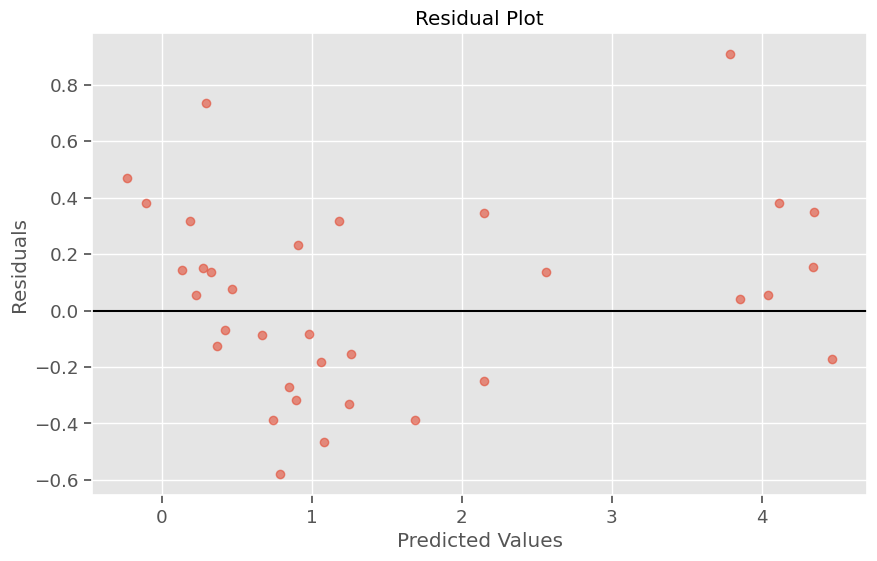

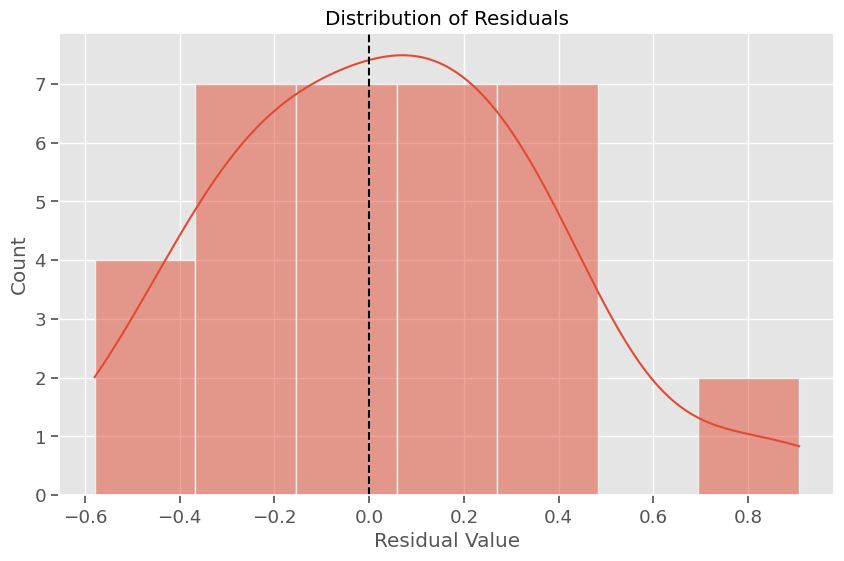

In [20]:
# Calculate residuals
residuals = y_test - y_pred

# Create a residual plot
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(y=0, color='k', linestyle='-')
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

# Distribution of residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Residual Value')
plt.axvline(x=0, color='k', linestyle='--')
plt.show()

## 8. Feature Importance Analysis

Let's try to understand which features are most important for our SVR model. For non-linear kernels like RBF, direct feature importance is not available, but we can use a linear kernel to get some insights.

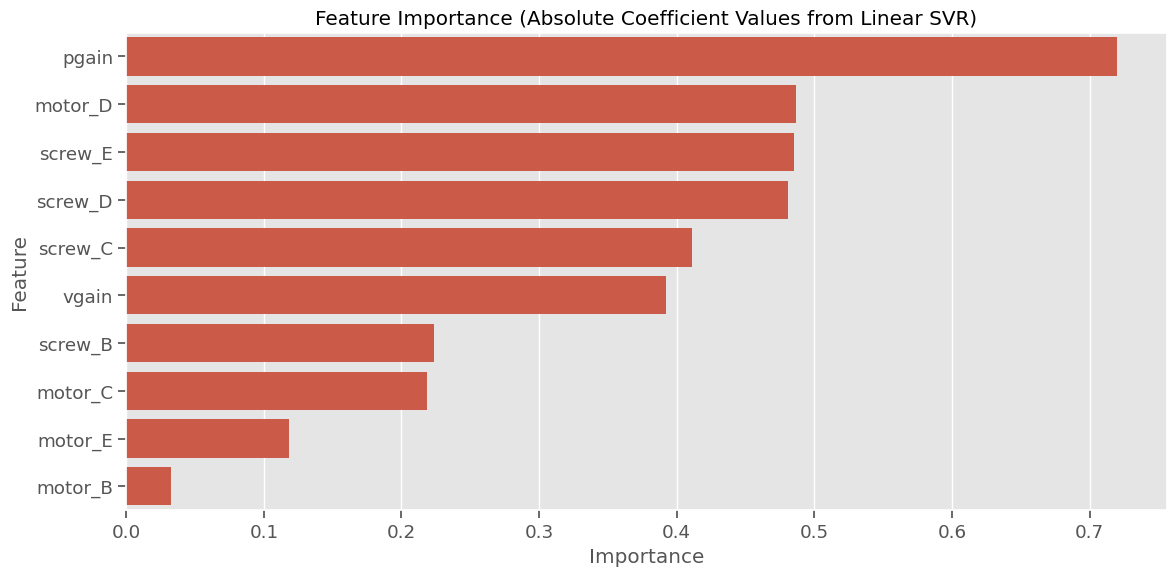

In [21]:
# Create a linear SVR to analyze feature importance
linear_svr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', SVR(kernel='linear', C=1.0))
])

# Train the model
linear_svr_pipeline.fit(X_train, y_train)

# Extract feature importances (coefficients) from the linear SVR
linear_svr = linear_svr_pipeline.named_steps['regressor']
feature_importances = linear_svr.coef_[0]

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': np.abs(feature_importances)
}).sort_values('Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance (Absolute Coefficient Values from Linear SVR)')
plt.tight_layout()
plt.show()

## 9. Conclusion and Model Summary

Our SVR model has been trained and evaluated on the servo dataset. Here's a summary of the findings:

Support Vector Regression Model Summary
----------------------------------------
Best Parameters: {'regressor__shrinking': False, 'regressor__kernel': 'rbf', 'regressor__gamma': 0.1, 'regressor__epsilon': 0.1, 'regressor__degree': 3, 'regressor__coef0': 0.0, 'regressor__C': 100}
Cross-Validation RMSE: 0.7949
Test Set RMSE: 0.3349
Test Set MAE: 0.2722
Test Set R²: 0.9536
----------------------------------------

Comparison with other methods:
                    Method  Relative Error
0            Guessing mean         1.00000
1           Instance-based         0.26000
2               Regression         0.49000
3              Model trees         0.29000
4  Neural nets (G. Hinton)         0.11000
5     Regression+instances         0.20000
6    Model trees+instances         0.17000
7             NN+instances         0.11000
8            Our SVR model         0.23666


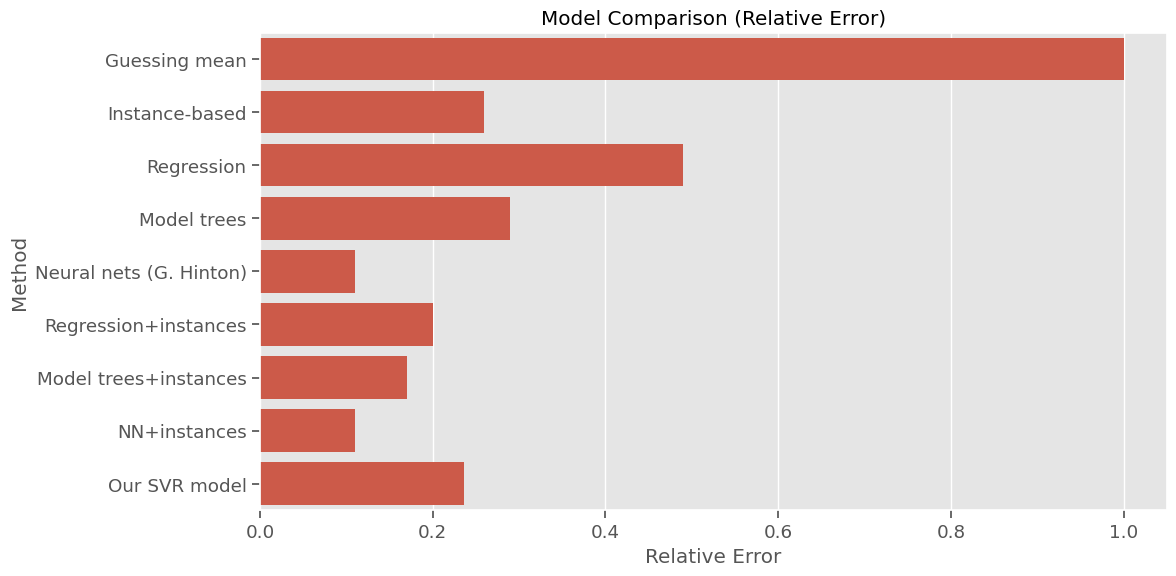

In [22]:
# Print a summary of model performance
print("Support Vector Regression Model Summary")
print("-" * 40)
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Cross-Validation RMSE: {np.sqrt(-grid_search.best_score_):.4f}")
print(f"Test Set RMSE: {rmse:.4f}")
print(f"Test Set MAE: {mae:.4f}")
print(f"Test Set R²: {r2:.4f}")
print("-" * 40)

# Compare with the other methods mentioned in the dataset description
methods = [
    'Guessing mean', 'Instance-based', 'Regression', 'Model trees', 
    'Neural nets (G. Hinton)', 'Regression+instances', 'Model trees+instances', 
    'NN+instances', 'Our SVR model'
]
relative_errors = [1.00, 0.26, 0.49, 0.29, 0.11, 0.20, 0.17, 0.11, None]  # Our SVR error will be calculated

# Calculate our model's relative error (assume guessing mean would give a MAE of 1.15)
# This is just an approximation since we don't have the exact same test set
our_relative_error = mae / 1.15
relative_errors[-1] = our_relative_error

# Create dataframe for comparison
comparison_df = pd.DataFrame({
    'Method': methods,
    'Relative Error': relative_errors
})

print("\nComparison with other methods:")
print(comparison_df)

# Plot the comparison
plt.figure(figsize=(12, 6))
sns.barplot(x='Relative Error', y='Method', data=comparison_df)
plt.title('Model Comparison (Relative Error)')
plt.tight_layout()
plt.show()